# Creation of Synthetic data

This file is used for the creation of synthetic data. We try to mimic the behavior of dynamic systems by creating data which have a stationary phase and a transition phase.

The stationary phase is determined by a quadratic function ($q_1 * x^2 + q_2 * x + q_3$). The transition phases are determined by a linear function ($l_1 * x + l_2$). The functions are selected according to the knowledge provided by the experts. Other functions can be adapted easily. The parameters q_1, q_2 and l_1 can be selected as one wishes using the variables in the parameters section a few cells down. We chose the parameters q_3 and l_2 to be 0 since it models our use case the best.

We have two ways to create data series. The first is a "hand-made" procedure having three jumps but also 2 smaller "continuity-like" jumps. The other way is a completely random series depending on the number of jumps. As an input we choose random values out of [0, 10], as time inputs we choose random integers out of [0, 10000].

## Preliminaries
### Import of libraries

In [1]:
# homemade functions
import Data_Processing as dp
import Global_Functions as gf

# include python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil

In [2]:
np.random.seed(123)

### Parameters specification

In [3]:
q_1 = 40
q_2 = 0
l_1 = 10

qdr_params = [q_1,q_2,0]
lin_params = [l_1,0]

Since we want to sample the data down, we need to specify the ratio at which the data should be downsampled. In our case we sample the data to one data point per second, therefore resulting in a SAMPLE_RATIO of 1. If we want to sample once every minute, the SAMPLE_RATIO should be 1/60.

In [4]:
SAMPLE_RATIO = 0.5

### Folder specifications

In [5]:
save_at = "../Data/Synthetic_Data/Without_Noise/Sample_Ratio_" + str(SAMPLE_RATIO) + "/" + "quadratic_{0}_{1}_linear_{2}/".format(q_1, q_2, l_1)
gf.check_folder(save_at)

Folder already exists.


## Auxiliary methods

In [6]:
def linear_func(x, params):
    a, b = params
    return a*x + b

In [7]:
def quadr_func(x, params):
    p1, p2, p3 = params
    return p1 * x**2 + p2*x + p3

In [8]:
def downsample_dataframe(data_full):
    df = pd.DataFrame()
    #determine sample size depending on duration of experiment and sample ratio (specified above)
    sample_size = ceil(data_full['time'][len(data_full)-1] * SAMPLE_RATIO)
    
    if df.isnull().any().any():
        df = df.fillna(0)

    for col in data_full.columns:
        df[col] = dp.downsample_data(data_full['time'], data_full[col], sample_size)

    return df

In [9]:
def fill_data(time_splits, value_splits, df_time):
    #initialize empty numpy-arrays
    time = np.empty(len(df_time))
    values = np.empty(len(df_time))
    ix_start = 0

    for i in range(len(time_splits)-1):
        lower = ceil(time_splits[i]) # find beginning of time frame
        upper = ceil(time_splits[i+1]) # find end of time frame
        
        ix_start = np.argmax(df_time >= lower) #find index where lower timestep is surpassed      
        ix_end = np.argmax(df_time > upper) #find index where lower timestep is surpassed      
        
        v = value_splits[i]
        values[ix_start:ix_end] = v
    values[time_splits[-2]:time_splits[-1]] = value_splits[-2]
    values[time_splits[-1]:] = value_splits[-1]
    return values

In [10]:
def create_synthetic_data(in_values, time, stat_function, stat_parameters, trans_function, trans_parameters):
    assert len(in_values) == len(time), 'input and time must have the same length'
    output = np.zeros(time[-1])
    stat_vals = np.zeros(len(in_values))
    
    # use static function to model static values
    for i in range(len(in_values)):
        stat_vals[i] = stat_function(in_values[i], stat_parameters)
        
    # in the first time sequence we exclude the transition --> refer to final thesis for more detail.
    # add normal distributed noise
    for j in range(time[0], time[1]):
        output[j] = stat_vals[0]# + np.random.normal(0, stat_parameters[0])
    
    for t in range(len(time)-1):
        for i in range(time[t], time[t+1]):
            # if rise in input voltage
            if in_values[t] > in_values[t-1]:
                trans_value = output[i-1] + trans_function(1, trans_parameters)
                output[i] = min(trans_value, stat_vals[t])# + np.random.normal(0, stat_parameters[0])

            # if drop in input voltage
            else:
                trans_value = output[i-1] - trans_function(1, trans_parameters)
                output[i] = max(trans_value, stat_vals[t])# + np.random.normal(0, stat_parameters[0])
    return output

In [11]:
def create_dataframe(time_values, input_values, spec = ""):
    df = pd.DataFrame()
    
    df['el_power'] = create_synthetic_data(input_values, time_values, quadr_func, qdr_params, linear_func, lin_params)
    df['time'] = range(time_values[-1])
    df['input_voltage'] = fill_data(time_values, input_values, df['time'])
    
    df_downsampled = downsample_dataframe(df)
    
    df_downsampled.to_csv(save_at + "synthetic_data_{0}.csv".format(spec),
              index = False, sep = "|", encoding = "utf-8")
    return df

In [12]:
def create_plot(exp, spec = ""):
    fig2, ax1 = plt.subplots(figsize = (10,8))
    line1, = ax1.plot(exp['time'], exp['el_power'], color = gf.get_color('grey'), label = 'el_power')
    ax1.set_ylabel('electric power (W)', color = gf.get_color('grey'), fontsize = 20)
    ax1.tick_params(axis='y', labelcolor= gf.get_color('grey'))
    ax1.set_ylim([-10, quadr_func(10.5, qdr_params)])
    ax1.set_xlabel('Time (s)', fontsize = 20)
    
    ax2 = ax1.twinx()
    line2, = ax2.plot(exp['time'], exp['input_voltage'], color = gf.get_color('red'), label = 'input_voltage')
    ax2.set_ylabel('voltage (V)', color = gf.get_color('red'), fontsize = 20)
    ax2.tick_params(axis='y', labelcolor= gf.get_color('red'))
    ax2.set_ylim([-0.5, 10.5])
    ax2.legend([line1, line2], ['el. power', 'voltage'], loc = 'upper right')
    ax1.set_title('Synthetic data: input and power', fontsize = 28)
    fig2.tight_layout()
    fig2.savefig(save_at + 'input_{0}.png'.format(spec))
    fig2.savefig(save_at + 'input_{0}.svg'.format(spec))

## Create individual slope with jumps and some continuity

In [13]:
input_values_hand = [2, 5, 1, 4, 8, 8.5, 9, 2, 3]
time_values_hand = [0, 1500, 2100, 2470, 3043, 4075, 4200, 6000, 7000]

In [14]:
df = create_dataframe(time_values_hand, input_values_hand, "hand")

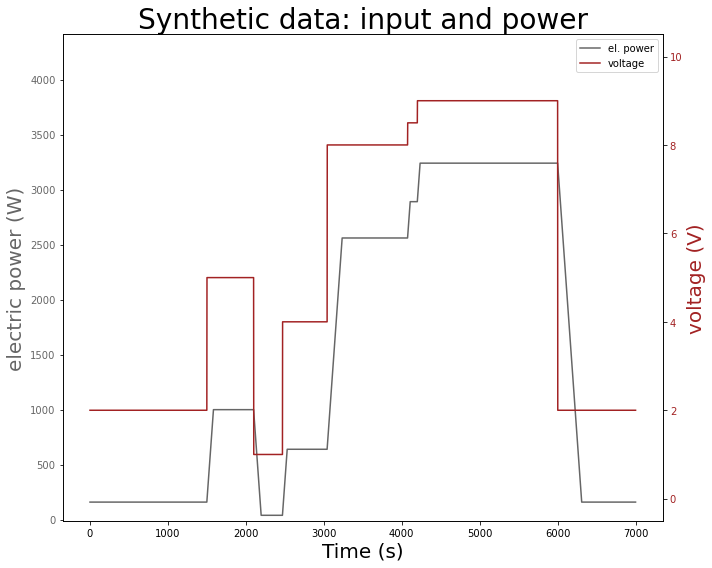

In [15]:
create_plot(df, "hand")

## Create more inputs by number of jumps

In [16]:
def create_dfs_jumps(jumps = 3):
    input_values = 7* np.random.random(jumps*2) + 3
    time_values = np.random.randint(0, 10000, size=jumps*2-1)
    time_values = np.append(time_values, 0)
    time_values.sort()
    
    df_jump = create_dataframe(time_values=time_values, input_values=input_values, spec = "jumps_{0}".format(jumps))
    create_plot(df_jump, "jumps_{0}".format(jumps))

In [17]:
for i in range(300):
    jumps = np.random.randint(1, 7)
    input_values = 10 * np.random.random(2*jumps)
    time_values = np.random.randint(0,10000, size = 2*jumps -1)
    time_values = np.append(time_values, 0)
    time_values.sort()
    
    df = create_dataframe(time_values = time_values, input_values = input_values)
    df.to_csv(save_at + "sample_{0}.csv".format(str(i)), sep = "|", encoding = "utf-8")